In [171]:
# Librairie de base
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
pd.options.mode.chained_assignment = None
import statistics
import warnings
warnings.filterwarnings("ignore")

# Feature_Selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest,chi2

# Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelEncoder

# Naive Models
from sklearn import dummy

# Neighbors Models
from sklearn.neighbors import KNeighborsRegressor

# Model Selection
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
# Linear Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# Ensemble Models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Pipeline
from sklearn.pipeline import make_pipeline

# Metrics
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

# Feature importance
from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance
import shap

# Data Viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Option d'affichage
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

# 0. Préparation du dataset

## 01. Pre-processing

In [2]:
# Chargement des données
data = pd.read_csv('cleaned_dataset.csv').drop(['Unnamed: 0','SiteEnergyUse(kBtu)'],axis=1)

In [3]:
# catégorielle
cat = []
# numérique
num = []

target = ['SiteEnergyUse(kBtu)','TotalGHGEmissions']

for col in data.columns:
    if data[col].dtype == 'object':
        cat.append(col)
    elif col not in target:
        num.append(col)
    else:
        pass

In [4]:
X = pd.get_dummies(data).drop('TotalGHGEmissions',axis=1)

In [5]:
# Normalisation des données via minmax car données à différentes échelles et non-normales
XminmaxESS = MinMaxScaler().fit_transform(X)

In [6]:
# Enlever la colonne ENERGYSTARScore, soit la 4ème colonne, donc rang 3
Xminmax = np.delete(XminmaxESS,3,1)

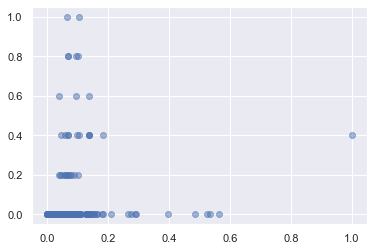

In [7]:
%matplotlib inline
# Pas de différence significative, donc on passe par MinMaxScaler
plt.scatter(Xminmax[:,2],Xminmax[:,3],alpha=0.5)

In [8]:
# Passage au log
transformer = FunctionTransformer(
                                  np.log,
                                  inverse_func = np.exp,
                                  check_inverse = True
                                 )

## 02. Passage au log

In [9]:
# Définition de la target
y = data['TotalGHGEmissions']

In [10]:
y_log = transformer.transform(y)

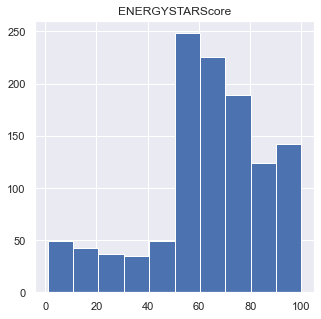

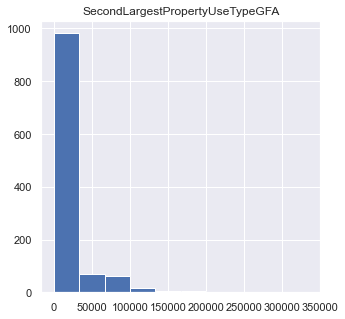

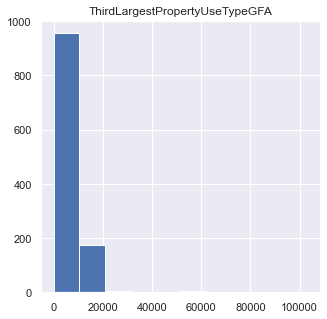

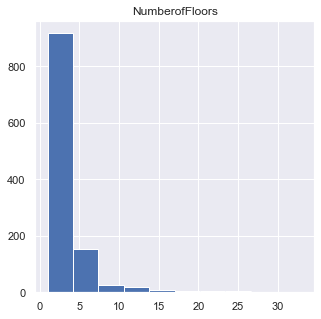

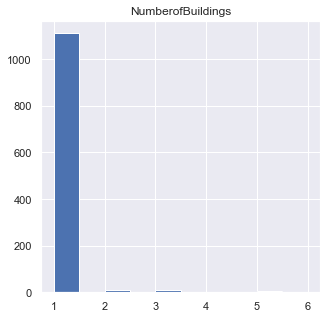

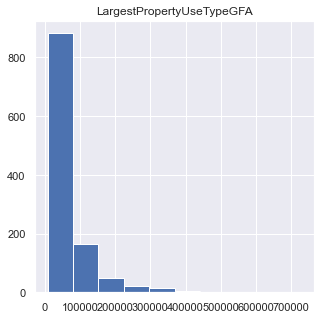

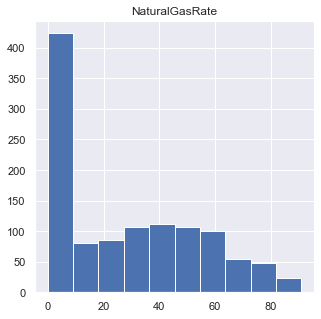

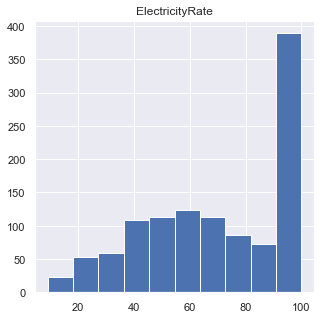

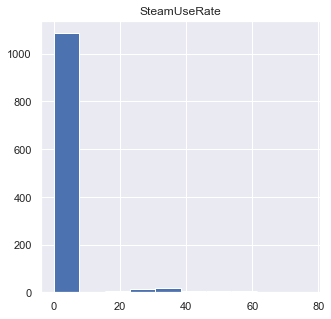

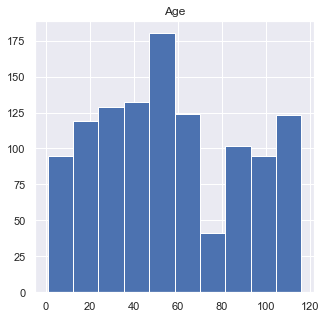

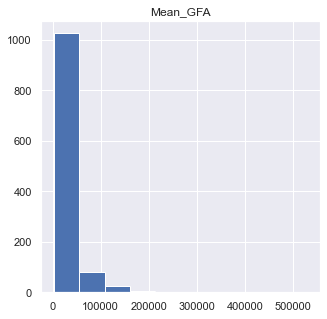

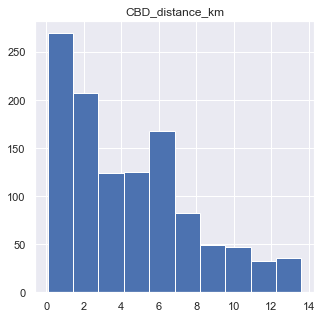

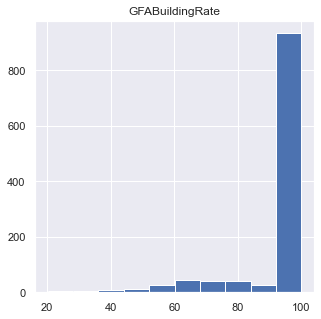

In [11]:
# Vérification de la normalité des données
for col in data[num].columns: 
    plt.figure(figsize=(5,5))
    plt.hist(data[col])
    plt.title(col)

Text(0.5, 1.0, 'Log TotalGHGEmissions')

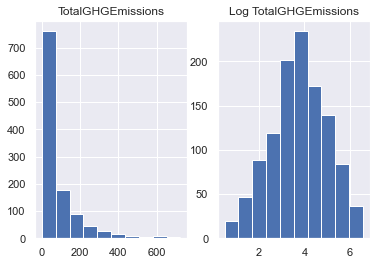

In [12]:
# Normalise les données
%matplotlib inline
f, ax = plt.subplots(1,2)

ax[0].hist(y)
ax[0].set_title('TotalGHGEmissions')
ax[1].hist(y_log)
ax[1].set_title('Log TotalGHGEmissions')

In [13]:
# Ajouter une target log + faire des listes avec / sans log pour comparer les corrélations
data['LogTotalGHGEmissions'] = np.log(data['TotalGHGEmissions'])
feats = [col for col in data.columns if col != 'LogTotalGHGEmissions']
logfeats = [col for col in data.columns if col != 'TotalGHGEmissions']

[Text(0.5, 1.0, 'transformed data')]

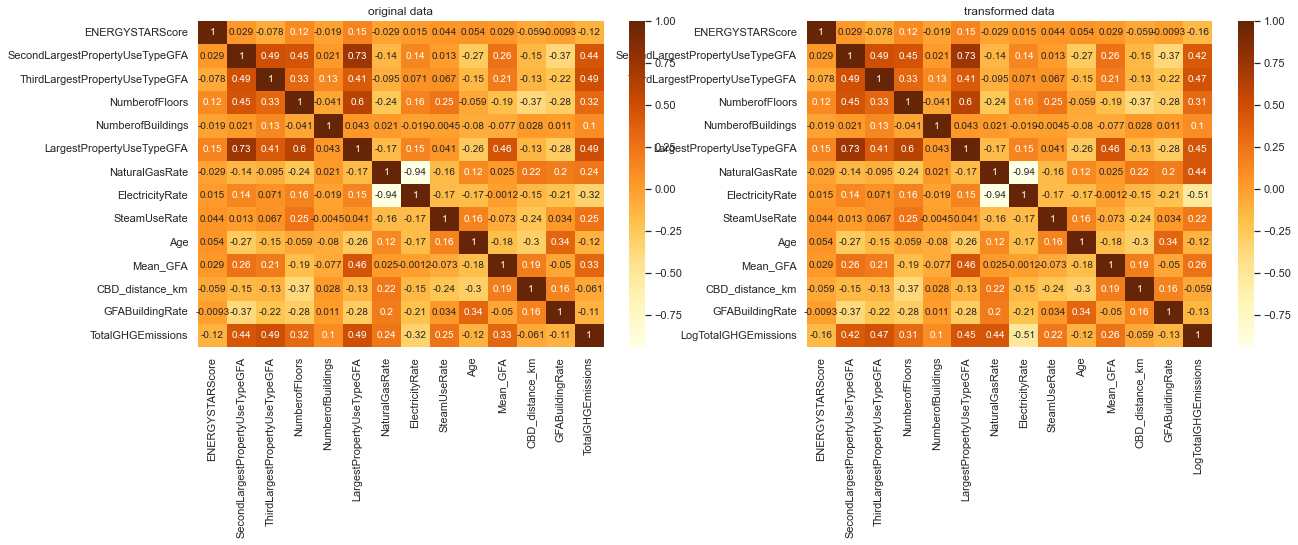

In [14]:
# Afficher une ligne et toutes les colonnes ?
# Permet de baisser le taux de corrélation entre la target et les autres variables
f, (ax1,ax2) = plt.subplots(1,2, figsize = (20,6))
sns.heatmap(data[feats].corr(),annot = True, cmap = 'YlOrBr', ax = ax1).set(title = 'original data')
sns.heatmap(data[logfeats].corr(),annot = True, cmap = 'YlOrBr', ax = ax2).set(title = 'transformed data')

## 04. Séparation du jeu de données

In [15]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(Xminmax, y, test_size=0.2,random_state=42)

In [16]:
X_train_ESS, X_test_ESS, y_train_ESS, y_test_ESS = model_selection.train_test_split(XminmaxESS, y, test_size=0.2,random_state=42)

In [17]:
y_train_log = np.log(y_train)
y_train_log = np.log(y_train)

## 05. Dummy Regressor

In [168]:
# Création d'un modèle Dummy
dum = dummy.DummyRegressor()

# Entraînement
dum.fit(X_train, y_train_log)

DummyRegressor()

In [169]:
# Prédiction sur le jeu de test
y_pred_dum = dum.predict(X_test)

In [172]:
# Evaluate
print("RMSE Dummy : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y_test, y_pred_dum))),
      "\nr2 Dummy : {:.4f}".format(metrics.r2_score(y_test, y_pred_dum))
     )

RMSE Dummy : 128.28 
r2 Dummy : -0.5730


## 06. Random prediction

La moyenne des erreurs est bien plus élevée que pour un modèle Dummy, il n'est donc pas utile de garder cette approche naïve.

In [21]:
y_pred_rand = np.random.randint(np.min(y), np.max(y), y_test.shape)

In [174]:
print("RMSE Random : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y_test, y_pred_rand))),
      "\nr2 Random : {:.4f}".format(metrics.r2_score(y_test, y_pred_rand)))

RMSE Random : 368.91 
r2 Random : -12.0084


# 1. Linear Regression

In [23]:
# On crée un modèle de régression linéaire vide
lr = LinearRegression()

In [24]:
# Utilisation d'une grille de recherche des meilleurs paramètres avec validation croisée
linearreg = GridSearchCV(lr, param_grid = {},
                       return_train_score = True,
                       scoring = 'r2', cv =5)

# On entraine le modèle à partir des données d'entrainement
linearreg.fit(X_train,y_train_log)

GridSearchCV(cv=5, estimator=LinearRegression(), param_grid={},
             return_train_score=True, scoring='r2')

In [25]:
# On affiche le meilleur score possible du validation set par rapport aux données d'entrainement
print('Train Score : {:.2f}'.format(linearreg.best_score_))

Train Score : -181716146487795187712.00


In [26]:
# On crée un modèle de régression Ridge vide
lr = LinearRegression()

# Appliquer les paramètres de la grille
lr.set_params(**linearreg.best_params_)

# Recréer un split du jeu de données pour entrainer le modèle

lr.fit(X_train, y_train)

# On crée une variable contenant des targets prédites à partir des données de test
y_pred_lr = lr.predict(X_test)

# 2. Ridge Regression

In [27]:
# On crée un modèle de régression Ridge vide
lr_ridge = Ridge(random_state=0)

In [28]:
# Initialisation des paramètres
n_alphas = 100
alpha = np.linspace(0.05, 0.25, n_alphas)
params = {'alpha' : alpha}

# Utilisation d'une grille de recherche des meilleurs paramètres avec validation croisée
grid_ridge = GridSearchCV(lr_ridge, param_grid = params, 
                          return_train_score = True,
                          scoring = 'r2', cv = 5)

In [29]:
# On entraine le modèle à partir des données d'entrainement
grid_ridge.fit(X_train,y_train_log)

GridSearchCV(cv=5, estimator=Ridge(random_state=0),
             param_grid={'alpha': array([0.05      , 0.0520202 , 0.0540404 , 0.05606061, 0.05808081,
       0.06010101, 0.06212121, 0.06414141, 0.06616162, 0.06818182,
       0.07020202, 0.07222222, 0.07424242, 0.07626263, 0.07828283,
       0.08030303, 0.08232323, 0.08434343, 0.08636364, 0.08838384,
       0.09040404, 0.09242424, 0.09444444, 0.09646465, 0.09848485,
       0.1005...
       0.19141414, 0.19343434, 0.19545455, 0.19747475, 0.19949495,
       0.20151515, 0.20353535, 0.20555556, 0.20757576, 0.20959596,
       0.21161616, 0.21363636, 0.21565657, 0.21767677, 0.21969697,
       0.22171717, 0.22373737, 0.22575758, 0.22777778, 0.22979798,
       0.23181818, 0.23383838, 0.23585859, 0.23787879, 0.23989899,
       0.24191919, 0.24393939, 0.2459596 , 0.2479798 , 0.25      ])},
             return_train_score=True, scoring='r2')

In [30]:
grid_ridge.best_params_

{'alpha': 0.151010101010101}

In [31]:
# On affiche le meilleur score possible du validation set par rapport aux données d'entrainement
print('Best Train Score : {:.2f}'.format(grid_ridge.best_score_))

Best Train Score : 0.79


In [32]:
# On crée un modèle de régression Ridge vide
lr_ridge = Ridge(random_state=0)

# Appliquer les paramètres de la grille
lr_ridge.set_params(**grid_ridge.best_params_)

# Recréer un split du jeu de données pour entrainer le modèle
lr_ridge.fit(X_train, y_train_log)

# On crée une variable contenant des targets prédites à partir des données de test
y_pred_ridge = lr.predict(X_test)

# 3. Lasso Regression

In [33]:
# On crée un modèle de régression linéaire
lr_lasso = Lasso(random_state=0)

In [34]:
# Initialisation des paramètres
alpha = np.linspace(0.0005, 0.01, 100)
params = {'alpha' : alpha}

# Utilisation d'une grille de recherche des meilleurs paramètres avec validation croisée
grid_lasso = GridSearchCV(lr_lasso, param_grid = params, 
                          return_train_score = True,
                          scoring = 'r2', cv = 5)

# On entraine le modèle à partir des données d'entrainement
grid_lasso.fit(X_train,y_train_log)

GridSearchCV(cv=5, estimator=Lasso(random_state=0),
             param_grid={'alpha': array([0.0005    , 0.00059596, 0.00069192, 0.00078788, 0.00088384,
       0.0009798 , 0.00107576, 0.00117172, 0.00126768, 0.00136364,
       0.0014596 , 0.00155556, 0.00165152, 0.00174747, 0.00184343,
       0.00193939, 0.00203535, 0.00213131, 0.00222727, 0.00232323,
       0.00241919, 0.00251515, 0.00261111, 0.00270707, 0.00280303,
       0.00...
       0.00721717, 0.00731313, 0.00740909, 0.00750505, 0.00760101,
       0.00769697, 0.00779293, 0.00788889, 0.00798485, 0.00808081,
       0.00817677, 0.00827273, 0.00836869, 0.00846465, 0.00856061,
       0.00865657, 0.00875253, 0.00884848, 0.00894444, 0.0090404 ,
       0.00913636, 0.00923232, 0.00932828, 0.00942424, 0.0095202 ,
       0.00961616, 0.00971212, 0.00980808, 0.00990404, 0.01      ])},
             return_train_score=True, scoring='r2')

In [35]:
grid_lasso.best_params_

{'alpha': 0.0013636363636363637}

In [36]:
# On affiche le meilleur score possible du validation set par rapport aux données d'entrainement
print('Best Score : {:.2f}'.format(grid_lasso.best_score_))

Best Score : 0.79


In [37]:
# On crée un modèle de régression Ridge vide
lr_lasso = Lasso(random_state=0)

# Appliquer les paramètres de la grille
lr_lasso.set_params(**grid_lasso.best_params_)

# Recréer un split du jeu de données pour entrainer le modèle
lr_lasso.fit(X_train, y_train)

# On crée une variable contenant des targets prédites à partir des données de test
y_pred_lasso = lr_lasso.predict(X_test)

# 4. Elastic Net

In [101]:
# On crée un modèle de régression linéaire
elastic_net = ElasticNet(random_state=0)

In [102]:
# Initialisation des paramètres
n_alphas = 50
alpha = np.linspace(0.0005, 0.0015, n_alphas)
l1_ratio = np.linspace(0, 1, n_alphas)
params = {
    'alpha' : alpha,
    'l1_ratio' : l1_ratio
         }

# Utilisation d'une grille de recherche des meilleurs paramètres avec validation croisée
grid_elastic = GridSearchCV(elastic_net, param_grid = params, 
                          return_train_score = True,
                          scoring = 'r2', cv = 5)

# On entraine le modèle à partir des données d'entrainement
grid_elastic.fit(X_train,y_train_log)

GridSearchCV(cv=5, estimator=ElasticNet(random_state=0),
             param_grid={'alpha': array([0.0005    , 0.00052041, 0.00054082, 0.00056122, 0.00058163,
       0.00060204, 0.00062245, 0.00064286, 0.00066327, 0.00068367,
       0.00070408, 0.00072449, 0.0007449 , 0.00076531, 0.00078571,
       0.00080612, 0.00082653, 0.00084694, 0.00086735, 0.00088776,
       0.00090816, 0.00092857, 0.00094898, 0.00096939, 0.0009898...
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])},
             return_train_score=True, scoring='r2')

In [103]:
grid_elastic.best_params_

{'alpha': 0.0012959183673469387, 'l1_ratio': 1.0}

In [104]:
# On affiche le meilleur score possible du validation set par rapport aux données d'entrainement
print('Best Score : {:.2f}'.format(grid_elastic.best_score_))

Best Score : 0.79


In [105]:
# On crée un modèle de régression Ridge vide
elastic_net = ElasticNet(random_state=0)

# Appliquer les paramètres de la grille
elastic_net.set_params(**grid_elastic.best_params_)

# Recréer un split du jeu de données pour entrainer le modèle
elastic_net.fit(X_train, y_train)

# On crée une variable contenant des targets prédites à partir des données de test
y_pred_elastic = elastic_net.predict(X_test)

# 5. Random Forest

In [43]:
# Encapsulage du modèle (hyperparamètre choisi avec RandomizedSearchCV)
randomforest = RandomForestRegressor(max_features='sqrt',random_state=0)

In [44]:
n_estimators = np.arange(1,
                         100,
                         1,
                         dtype=int)
max_depth = np.arange(15,
                      30,
                      1,
                      dtype=int)
min_samples_split =  np.arange(3,
                              15,
                              1,
                              dtype=int)
min_samples_leaf = np.arange(0,
                            150,
                            2,
                            dtype=int)
max_samples = np.arange(0,.3,.01)

params = {'n_estimators' : n_estimators, 
          'max_depth' : max_depth,
          'min_samples_split' : min_samples_split,
          'min_samples_leaf' : min_samples_leaf,
          'max_samples' : max_samples
          }

In [45]:
# Utilisation d'une grille de recherche des meilleurs paramètres avec validation croisée
grid_rf = RandomizedSearchCV(randomforest, params, n_iter=50,
                          return_train_score = True,
                          scoring = 'r2', cv = 3)

# On entraine le modèle à partir des données d'entrainement
grid_rf.fit(X_train,y_train_log)

RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(max_features='sqrt',
                                                   random_state=0),
                   n_iter=50,
                   param_distributions={'max_depth': array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                                        'max_samples': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28...
                                        'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                   return_train_score=True, scoring='r2')

In [46]:
grid_rf.best_params_

{'n_estimators': 99,
 'min_samples_split': 6,
 'min_samples_leaf': 4,
 'max_samples': 0.11,
 'max_depth': 28}

In [47]:
# On affiche le meilleur score possible du validation set par rapport aux données d'entrainement
print('Best Score : {:.3f}'.format(grid_rf.best_score_))

Best Score : 0.672


In [48]:
# On crée un modèle de régression Ridge vide
randomforest = RandomForestRegressor(random_state=0)

# Appliquer les paramètres de la grille
randomforest.set_params(**grid_rf.best_params_)

# Recréer un split du jeu de données pour entrainer le modèle
randomforest.fit(X_train, y_train)

# On crée une variable contenant des targets prédites à partir des données de test
y_pred_rf = randomforest.predict(X_test)

# 6. KNN Regressor

In [49]:
# Encapsulage du modèle (hyperparamètre choisi avec GridSearchCV)
knn = KNeighborsRegressor(metric='manhattan')

In [50]:
KNeighborsRegressor().get_params(deep=True)

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [51]:
# Initialisation des paramètres
n_neighbors = np.linspace(1, 20, 19).astype(int)

params = {'n_neighbors' : n_neighbors}

# Utilisation d'une grille de recherche des meilleurs paramètres avec validation croisée
grid_knn = GridSearchCV(knn, param_grid=params,
                          return_train_score = True,
                          scoring = 'r2', cv = 5)

# On entraine le modèle à partir des données d'entrainement
grid_knn.fit(X_train,y_train_log)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(metric='manhattan'),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 20])},
             return_train_score=True, scoring='r2')

In [52]:
grid_knn.best_params_

{'n_neighbors': 6}

In [53]:
# On affiche le meilleur score possible du validation set par rapport aux données d'entrainement
print('Best Score : {:.2f}'.format(grid_knn.best_score_))

Best Score : 0.56


In [54]:
# On crée un modèle de régression Ridge vide
knn = KNeighborsRegressor()

# Appliquer les paramètres de la grille
knn.set_params(**grid_knn.best_params_)

# Recréer un split du jeu de données pour entrainer le modèle
knn.fit(X_train, y_train)

# On crée une variable contenant des targets prédites à partir des données de test
y_pred_knn = knn.predict(X_test)

# 7. GradientBoostingRegressor

In [55]:
# On crée un modèle de régression linéaire
gbr = GradientBoostingRegressor(loss='huber',random_state=0)

In [56]:
GradientBoostingRegressor().get_params(deep=True)

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [57]:
# Initialisation des paramètres
n_estimators = np.arange(60,
                         100,
                         1,
                         dtype=int)

params = {'n_estimators':n_estimators}

# Utilisation d'une grille de recherche des meilleurs paramètres avec validation croisée
grid_gbr = GridSearchCV(gbr, params,
                          return_train_score = True,
                          scoring = 'r2', cv = 5)

# On entraine le modèle à partir des données d'entrainement
grid_gbr.fit(X_train,y_train_log)

GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(loss='huber', random_state=0),
             param_grid={'n_estimators': array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
       77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93,
       94, 95, 96, 97, 98, 99])},
             return_train_score=True, scoring='r2')

In [58]:
grid_gbr.best_params_

{'n_estimators': 93}

In [59]:
# On affiche le meilleur score possible du validation set par rapport aux données d'entrainement
print('Best Score : {:.2f}'.format(grid_gbr.best_score_))

Best Score : 0.92


In [60]:
# On crée un modèle de régression Ridge vide
gbr = GradientBoostingRegressor(random_state=0)

# Appliquer les paramètres de la grille
gbr.set_params(**grid_gbr.best_params_)

# Recréer un split du jeu de données pour entrainer le modèle
gbr.fit(X_train, y_train)

# On crée une variable contenant des targets prédites à partir des données de test
y_pred_gbr = gbr.predict(X_test)

# 8. XGBoost

In [61]:
# On crée un modèle de régression linéaire
xgbr = XGBRegressor(booster='gbtree')

In [70]:
# Initialisation des paramètres
n_estimators = np.arange(50,
                         150,
                         1,
                         dtype=int)
min_child_weight = np.arange(1,
                             10,
                             1)
max_depth = np.arange(1,
                      8,
                      5,
                      dtype=int)
learning_rate = np.linspace(.05,
                            .1,
                            20)
base_score = np.linspace(.20,
                         .5,
                         20)

params = {'base_score':base_score,
         'learning_rate':learning_rate,
         'max_depth':max_depth,
         'min_child_weight':min_child_weight,
         'n_estimators':n_estimators
         }

# Utilisation d'une grille de recherche des meilleurs paramètres avec validation croisée
grid_xgbr = RandomizedSearchCV(
                            estimator=xgbr,
                            param_distributions=params,
                            cv=5,
                            n_iter=70,
                            scoring ='r2',
                            n_jobs=5,
                            verbose=5,
                            return_train_score = True,
                            random_state=42
                                )

In [71]:
# On entraine le modèle à partir des données d'entrainement
grid_xgbr.fit(X_train,y_train_log)

Fitting 5 folds for each of 70 candidates, totalling 350 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster='gbtree',
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=No...
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149])},
                   random_state=42, return_train_score=True, scoring='r2',
                   verbose=5)

In [72]:
grid_xgbr.best_params_

{'n_estimators': 145,
 'min_child_weight': 5,
 'max_depth': 6,
 'learning_rate': 0.05789473684210526,
 'base_score': 0.3105263157894737}

In [73]:
# On affiche le meilleur score possible du validation set par rapport aux données d'entrainement
print('Best Score : {:.2f}'.format(grid_xgbr.best_score_))

Best Score : 0.94


## Generic

In [74]:
# On crée un modèle de régression Ridge vide
xgbr = XGBRegressor(random_state=0)

# Appliquer les paramètres de la grille
xgbr.set_params(**grid_xgbr.best_params_)

# Recréer un split du jeu de données pour entrainer le modèle
xgbr.fit(X_train, y_train)

# On crée une variable contenant des targets prédites à partir des données de test
y_pred_xgbr = xgbr.predict(X_test)

## ESS

In [75]:
# On crée un modèle de régression Ridge vide
xgbr_ESS = XGBRegressor(random_state=0)

# Appliquer les paramètres de la grille
xgbr_ESS.set_params(**grid_xgbr.best_params_)

# Recréer un split du jeu de données pour entrainer le modèle
xgbr_ESS.fit(X_train_ESS, y_train_ESS)

# On crée une variable contenant des targets prédites à partir des données de test
y_pred_xgbr_ESS = xgbr_ESS.predict(X_test_ESS)

# END. Interprétation des résultats

In [118]:
from sklearn import metrics

In [119]:
RMSE = {
'KNN':np.sqrt(metrics.mean_squared_error(y_test, y_pred_knn)),
'Linear':np.sqrt(metrics.mean_squared_error(y_test, y_pred_lr)),
'Ridge':np.sqrt(metrics.mean_squared_error(y_test, y_pred_ridge)),
'Lasso':np.sqrt(metrics.mean_squared_error(y_test, y_pred_lasso)),
'Elastic Net':np.sqrt(metrics.mean_squared_error(y_test, y_pred_elastic)),
'Random Forest':np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)),
'XGBoost':np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgbr)),
'GBR':np.sqrt(metrics.mean_squared_error(y_test, y_pred_gbr)),
'XGBoostESS':np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgbr_ESS))}

In [120]:
MAE = {
'KNN':metrics.mean_absolute_error(y_test, y_pred_knn),
'Linear':metrics.mean_absolute_error(y_test, y_pred_lr),
'Ridge':metrics.mean_absolute_error(y_test, y_pred_ridge),
'Lasso':metrics.mean_absolute_error(y_test, y_pred_lasso),
'Elastic Net':metrics.mean_absolute_error(y_test, y_pred_elastic),
'Random Forest':metrics.mean_absolute_error(y_test, y_pred_rf),
'XGBoost':metrics.mean_absolute_error(y_test, y_pred_xgbr),
'GBR':metrics.mean_absolute_error(y_test, y_pred_gbr),
'XGBoostESS':metrics.mean_absolute_error(y_test, y_pred_xgbr_ESS)}

In [121]:
MdAE = {
'KNN':metrics.median_absolute_error(y_test, y_pred_knn),
'Linear':metrics.median_absolute_error(y_test, y_pred_lr),
'Ridge':metrics.median_absolute_error(y_test, y_pred_ridge),
'Lasso':metrics.median_absolute_error(y_test, y_pred_lasso),
'Elastic Net':metrics.median_absolute_error(y_test, y_pred_elastic),
'Random Forest':metrics.median_absolute_error(y_test, y_pred_rf),
'XGBoost':metrics.median_absolute_error(y_test, y_pred_xgbr),
'GBR':metrics.median_absolute_error(y_test, y_pred_gbr),
'XGBoostESS':metrics.median_absolute_error(y_test, y_pred_xgbr_ESS)}

In [122]:
r2_train = {
'KNN':grid_knn.best_score_,
'Linear':linearreg.best_score_,
'Ridge':grid_ridge.best_score_,
'Lasso':grid_lasso.best_score_,
'Elastic Net':grid_elastic.best_score_,
'Random Forest':grid_rf.best_score_,
'XGBoost':grid_xgbr.best_score_,
'GBR':grid_gbr.best_score_,
'XGBoostESS':grid_xgbr.best_score_}

In [123]:
r2_test = {
'KNN':metrics.r2_score(y_test, y_pred_knn),
'Linear':metrics.r2_score(y_test, y_pred_lr),
'Ridge':metrics.r2_score(y_test, y_pred_ridge),
'Lasso':metrics.r2_score(y_test, y_pred_lasso),
'Elastic Net':metrics.r2_score(y_test, y_pred_elastic),
'Random Forest':metrics.r2_score(y_test, y_pred_rf),
'XGBoost':metrics.r2_score(y_test, y_pred_xgbr),
'GBR':metrics.r2_score(y_test, y_pred_gbr),
'XGBoostESS':metrics.r2_score(y_test, y_pred_xgbr_ESS)}

In [124]:
models = ['KNN',
          'Linear',
          'Ridge',
          'Lasso',
          'Elastic Net',
          'Random Forest',
          'XGBoost',
          'GBR',
          'XGBoostESS']
metrics = ['RMSE',
           'MAE',
           'MdAE',
           'r2_test']
dict_metrics = [RMSE,MAE,MdAE,r2_test]

In [125]:
df_metrics = pd.DataFrame(dict_metrics,index=metrics)
roundUp = df_metrics.apply(np.round,decimals=3)
roundUp

,KNN,Linear,Ridge,Lasso,Elastic Net,Random Forest,XGBoost,GBR,XGBoostESS
RMSE,93.590,83.449,83.449,83.354,83.360,48.055,44.490,44.401,44.331
MAE,51.592,45.828,45.828,45.832,45.834,24.036,18.442,17.900,18.576
MdAE,23.957,28.115,28.115,28.469,28.467,9.296,6.224,5.815,5.818
r2_test,0.163,0.334,0.334,0.336,0.336,0.779,0.811,0.812,0.812


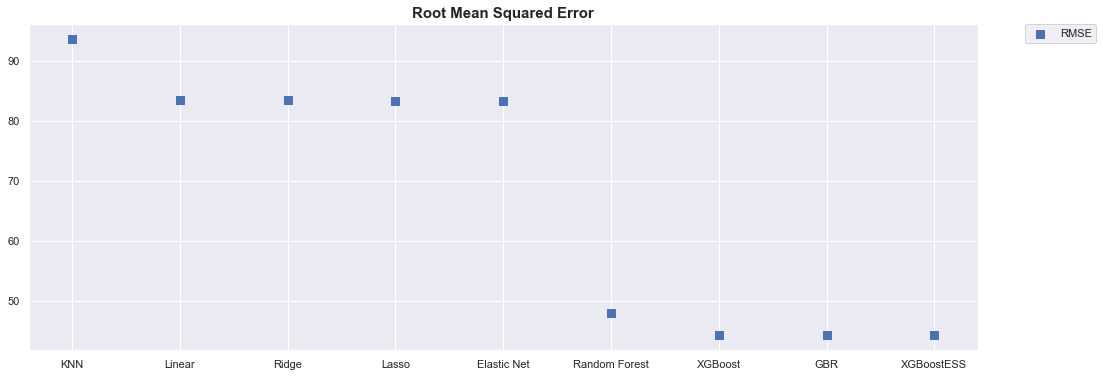

In [126]:
%matplotlib inline

plt.figure(figsize=(17, 6))

plt.scatter(models, list(RMSE.values()),label='RMSE',marker='s',c='b',s=50)
params = {'fontsize': 15,'fontweight':'bold'}
plt.title('Root Mean Squared Error',fontdict=params)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

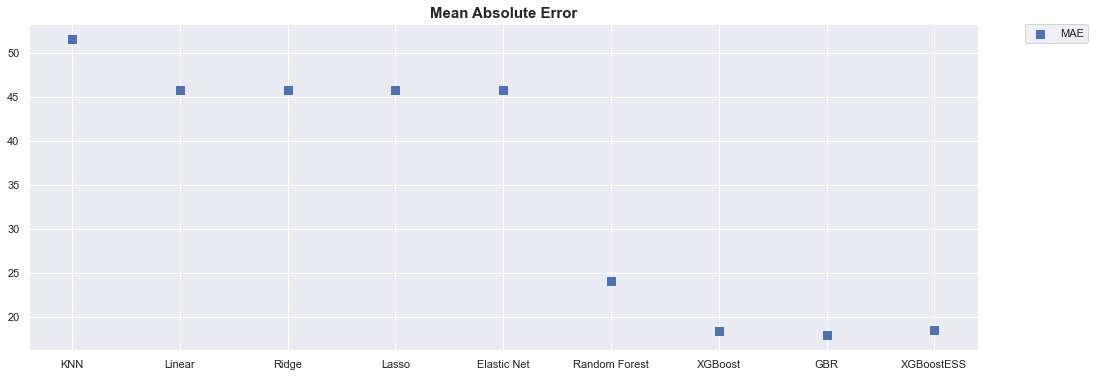

In [127]:
%matplotlib inline

plt.figure(figsize=(17, 6))

plt.scatter(models, list(MAE.values()),label='MAE',marker='s',c='b',s=50)

params = {'fontsize': 15,'fontweight':'bold'}
plt.title('Mean Absolute Error',fontdict=params)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

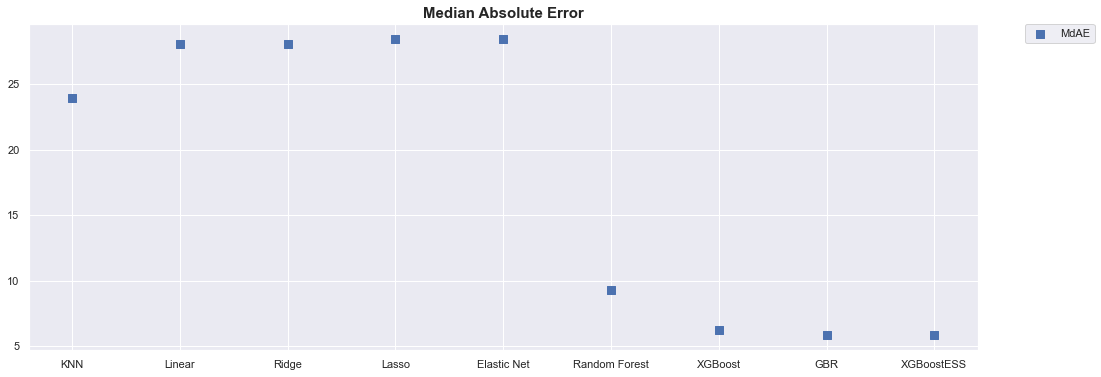

In [128]:
%matplotlib inline

plt.figure(figsize=(17, 6))

plt.scatter(models, list(MdAE.values()),label='MdAE',marker='s',c='b',s=50)

params = {'fontsize': 15,'fontweight':'bold'}
plt.title('Median Absolute Error',fontdict=params)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

(0.0, 1.0)

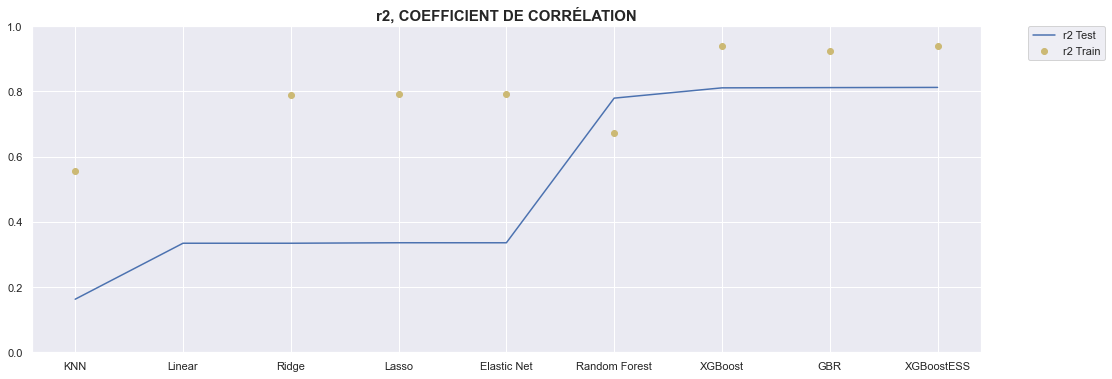

In [167]:
%matplotlib inline

plt.figure(figsize=(17, 6))

# Train
plt.scatter(models, list(r2_train.values()),label='r2 Train',marker='o',c='y')
plt.plot(models, list(r2_test.values()),label='r2 Test',marker='',c='b')

params = {'fontsize': 15,'fontweight':'bold'}
plt.title('r2, COEFFICIENT DE CORRÉLATION',fontdict=params)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.ylim([0,1])

In [134]:
# r2 ajusté pour l'Energy Star Score
print("r2 : {:.3f}".format(r2_score(y_test, y_pred_xgbr_ESS)))
print("r2 ajusté : {:.3f}".format(1 - (1-r2_score(y_test, y_pred_xgbr_ESS))*(len(data)-1)/(len(data)-XminmaxESS.shape[1]-1)))

r2 : 0.812
r2 ajusté : 0.803


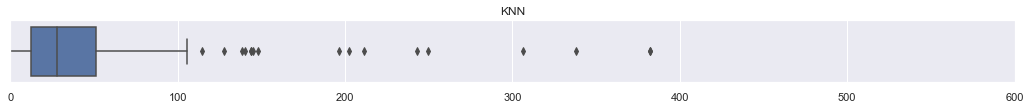

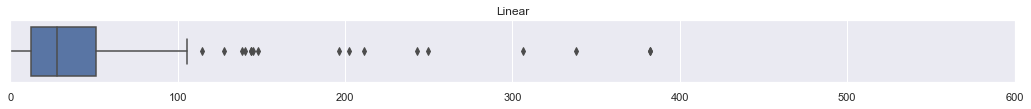

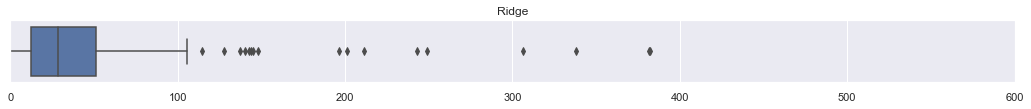

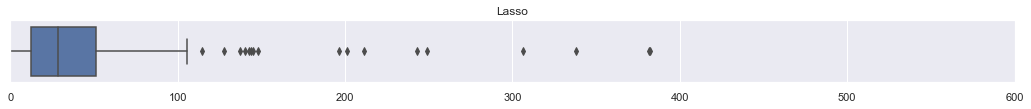

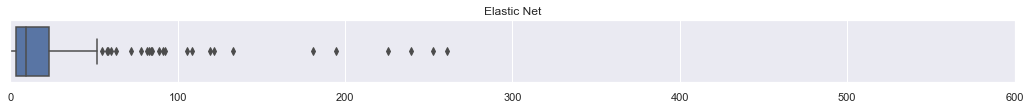

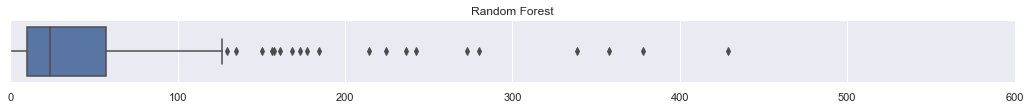

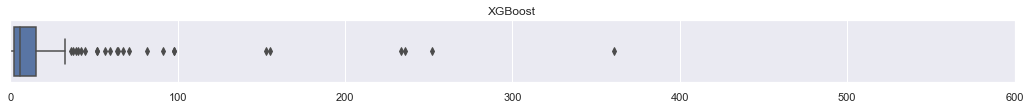

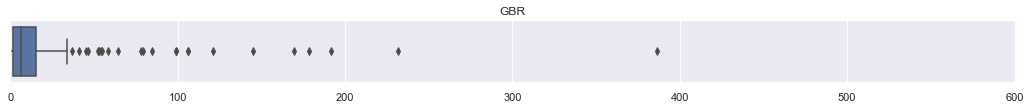

In [140]:
# Répartition de la taille des erreurs en norme euclidienne
%matplotlib inline
sns.set()

y_tests = [y_test,y_test,y_test,y_test,y_test,y_test,y_test,y_test]
y_preds = [y_pred_lr,y_pred_ridge,y_pred_lasso,y_pred_elastic,y_pred_rf,y_pred_knn,y_pred_gbr,y_pred_xgbr]

for i,j in zip(y_preds,models):
    fig, ax = plt.subplots(figsize=(18,1/200*len(y_test)))
    plt.xlim([-0.01,600])
    delta = np.sqrt(np.square(y_test-i))
    sns.boxplot(delta)
    plt.title(j)
    plt.xlabel('')

<IPython.core.display.Javascript object>


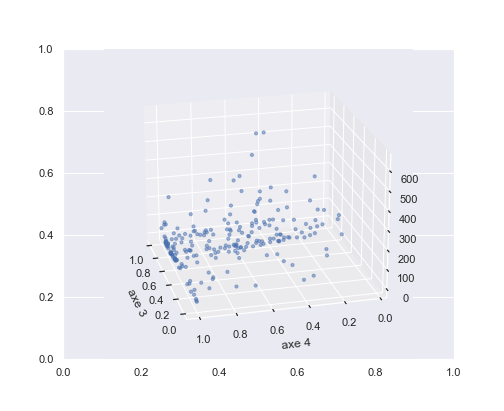

In [141]:
# Représentation graphique des données en dimensions
%matplotlib notebook
x = X_test[:,0]
y = X_test[:,6]
z = y_test
# Pour une dimension
fig = plt.subplots(figsize=(7,1/40*len(i)))
ax = plt.axes(projection ="3d")
plt.xlabel('axe 3')
plt.ylabel('axe 4')
# Creating plot
ax.scatter3D(x,y,z, s=10,alpha=.5)

# Feature importance

Ici le modèle selectionné est XG Boost avec une performance de 0.74

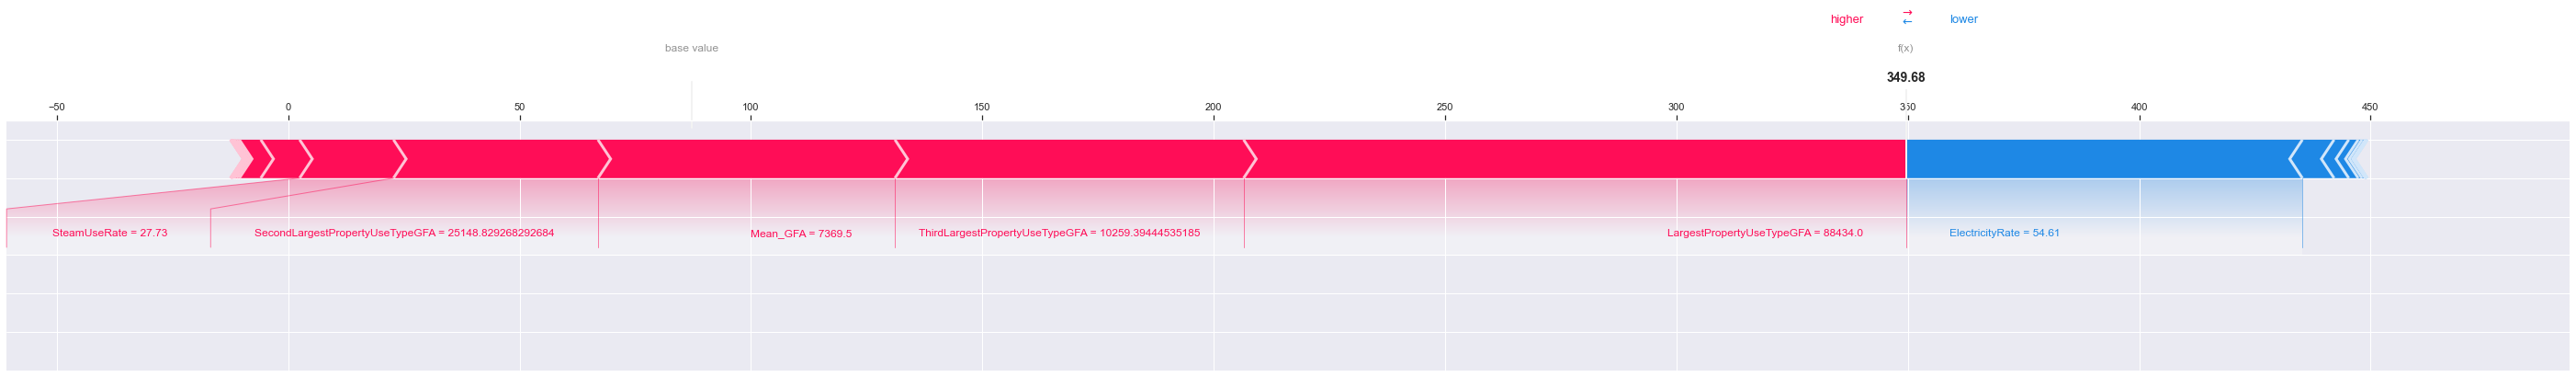

In [142]:
%matplotlib inline
explainer = shap.TreeExplainer(xgbr_ESS)
shap_values = explainer.shap_values(X)

shap.force_plot(explainer.expected_value,
                shap_values[0, :],
                pd.DataFrame(X).iloc[0, :],
                matplotlib=True,figsize=(50, 5))

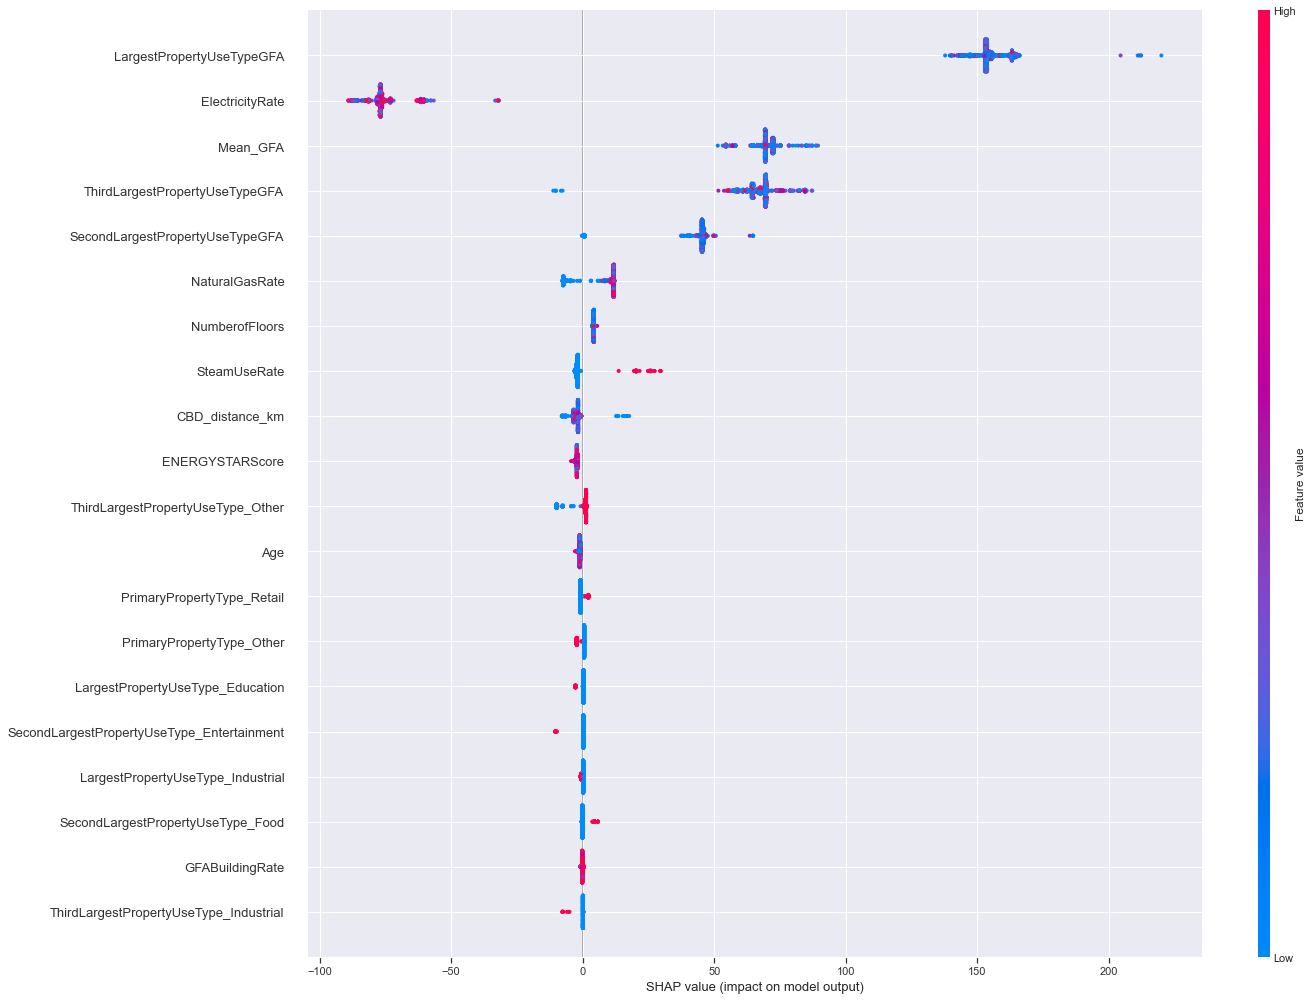

In [144]:
shap.summary_plot(shap_values, X, plot_size=(20,14))

In [164]:
import lime 
from lime import lime_tabular

lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns,
    mode='regression'
)

lime_exp = lime_explainer.explain_instance(
    data_row=pd.DataFrame(X_test).iloc[1],
    predict_fn=gbr.predict
)
lime_exp.show_in_notebook(show_table=True)